In [ ]:
# default_exp data.mixed_augmentation

# Label-mixing transforms

> Callbacks that perform data augmentation by mixing samples in different ways.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.external import *
from tsai.data.core import *
from tsai.data.preprocessing import *
from tsai.learner import *

In [ ]:
#export
from torch.distributions.beta import Beta

In [ ]:
#export
def reduce_loss(loss, reduction='mean'):
    "Reduce the loss based on `reduction`"
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

In [ ]:
#export
class MixHandler1D(Callback):
    "A handler class for implementing mixed sample data augmentation"
    run_valid = False

    def __init__(self, alpha=0.5):
        self.distrib = Beta(alpha, alpha)

    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf, self.learn.loss_func = self.learn.loss_func, self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf: loss = torch.lerp(lf(pred, *self.yb1), lf(pred, *yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

In [ ]:
#export
class MixUp1D(MixHandler1D):
    "Implementation of https://arxiv.org/abs/1710.09412"

    def __init__(self, alpha=.4):
        super().__init__(alpha)

    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0), ))
        self.lam = torch.max(lam, 1 - lam).to(self.x.device)
        shuffle = torch.randperm(self.y.size(0))
        xb1, self.yb1 = self.x[shuffle], tuple((self.y[shuffle], ))
        self.learn.xb = L(xb1, self.xb).map_zip(torch.lerp, weight=unsqueeze(self.lam, n=self.x.ndim - 1))
        if not self.stack_y: self.learn.yb = L(self.yb1, self.yb).map_zip(torch.lerp, weight=unsqueeze(self.lam, n=self.y.ndim - 1))        

In [ ]:
from tsai.models.utils import *
from tsai.models.ResNet import *
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
batch_tfms = TSStandardize()
dls = get_ts_dls(X, y, tfms=tfms, splits=splits, batch_tfms=batch_tfms)
model = build_model(ResNet, dls=dls)

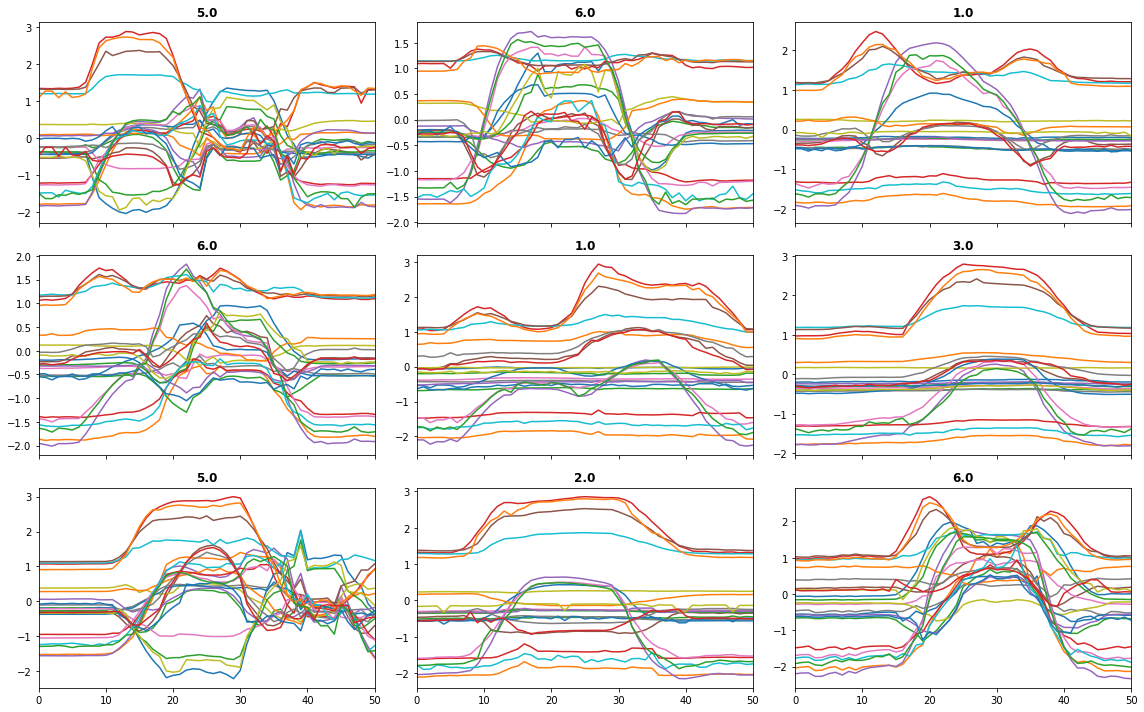

In [ ]:
learn = Learner(dls, model, cbs=MixUp1D(0.4)).show_batch()

In [ ]:
#export
class CutMix1D(MixHandler1D):
    "Implementation of `https://arxiv.org/abs/1905.04899`"

    def __init__(self, alpha=1.):
        super().__init__(alpha)

    def before_batch(self):
        bs, *_, seq_len = self.x.size()
        self.lam = self.distrib.sample((1, ))
        shuffle = torch.randperm(bs)
        xb1, self.yb1 = self.x[shuffle], tuple((self.y[shuffle], ))
        x1, x2 = self.rand_bbox(seq_len, self.lam)
        self.learn.xb[0][..., x1:x2] = xb1[..., x1:x2]
        self.lam = (1 - (x2 - x1) / float(seq_len)).item()
        if not self.stack_y:
            self.learn.yb = tuple(L(self.yb1, self.yb).map_zip(torch.lerp, weight=unsqueeze(self.lam, n=self.y.ndim - 1)))

    def rand_bbox(self, seq_len, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_seq_len = torch.round(seq_len * cut_rat).type(torch.long)

        # uniform
        cx = torch.randint(0, seq_len, (1, ))
        x1 = torch.clamp(cx - cut_seq_len // 2, 0, seq_len)
        x2 = torch.clamp(cx + cut_seq_len // 2, 0, seq_len)
        return x1, x2

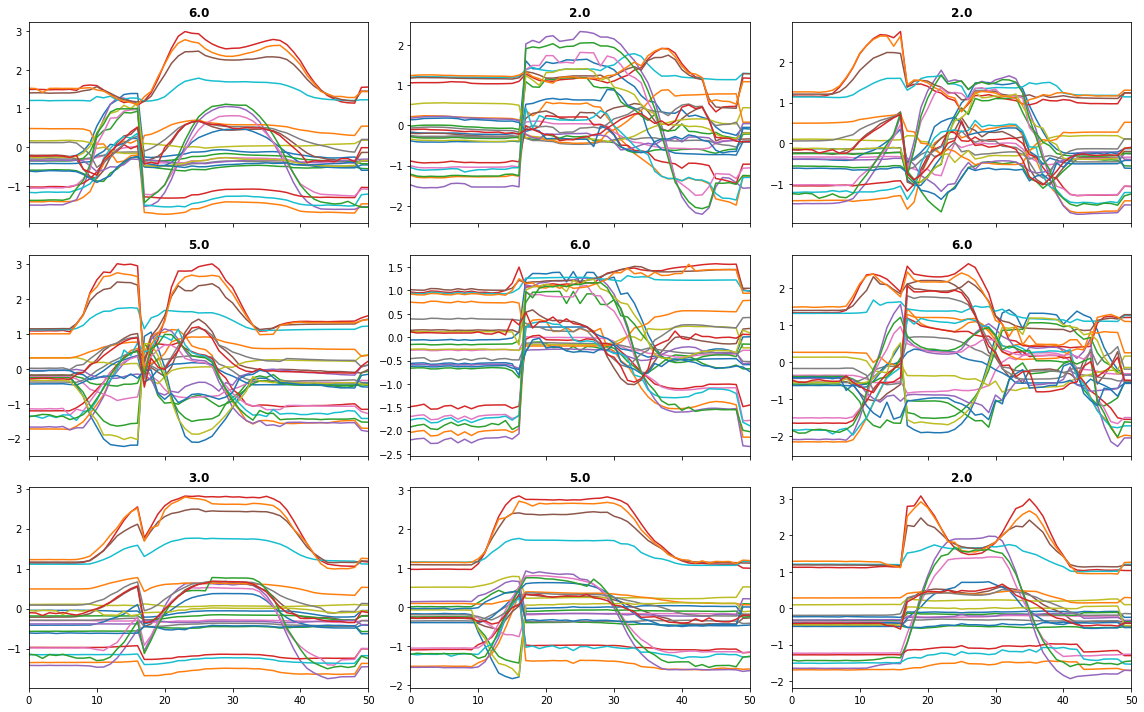

In [ ]:
learn = Learner(dls, model, cbs=CutMix1D(1.)).show_batch()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,1.869693,1.774227,00:03


In [ ]:
#hide
out = create_scripts(); beep(out)